<a href="https://colab.research.google.com/github/AiJared/job_matching_model/blob/main/job_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [6]:
# # Mock data creation (you'll replace this with your actual data loading)
# # This creates dummy data for development purposes
# # In a real scenario, you'd load your candidates.csv, jobs.csv, and matches.csv

# def create_mock_data():
#     # Create candidate data
#     candidates = pd.DataFrame({
#         'id': range(1, 101),
#         'skills': [
#             'python java sql', 'javascript html css', 'c++ python', 'java spring hibernate',
#             'react node.js mongodb', 'python django flask', 'java spring boot',
#             'javascript react redux', 'python numpy pandas', 'c# .net sql'
#         ] * 10,
#         'experience': np.random.randint(0, 11, 100),
#         'education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], 100),
#         'location': np.random.choice(['New York', 'San Francisco', 'Seattle', 'Austin', 'Chicago'], 100)
#     })

#     # Create job data
#     jobs = pd.DataFrame({
#         'id': range(1, 51),
#         'title': [
#             'Software Engineer', 'Web Developer', 'Data Scientist', 'Backend Developer',
#             'Frontend Developer', 'Full Stack Developer', 'DevOps Engineer',
#             'ML Engineer', 'Data Analyst', 'Software Developer'
#         ] * 5,
#         'required_skills': [
#             'python java sql', 'javascript html css', 'python pandas scikit-learn', 'java spring hibernate',
#             'react javascript css', 'python django javascript', 'aws docker kubernetes',
#             'python tensorflow keras', 'sql python tableau', 'c# .net sql'
#         ] * 5,
#         'min_experience': np.random.randint(0, 6, 50),
#         'required_education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], 50),
#         'location': np.random.choice(['New York', 'San Francisco', 'Seattle', 'Austin', 'Chicago'], 50)
#     })

#     # Create match data (some good matches, some poor matches)
#     matches = []
#     for _ in range(300):
#         candidate_id = np.random.randint(1, 101)
#         job_id = np.random.randint(1, 51)

#         # Simplistic match score calculation for demo
#         candidate = candidates[candidates['id'] == candidate_id].iloc[0]
#         job = jobs[jobs['id'] == job_id].iloc[0]

#         # Basic matching logic - more sophisticated in real implementation
#         skill_match = len(set(candidate['skills'].split()) & set(job['required_skills'].split())) / len(set(job['required_skills'].split()))
#         exp_match = 1 if candidate['experience'] >= job['min_experience'] else 0.5
#         edu_match = 1 if candidate['education'] == job['required_education'] else 0.7
#         loc_match = 1 if candidate['location'] == job['location'] else 0.8

#         match_score = (skill_match * 0.5 + exp_match * 0.3 + edu_match * 0.1 + loc_match * 0.1)

#         matches.append({
#             'candidate_id': candidate_id,
#             'job_id': job_id,
#             'match_score': match_score
#         })

#     matches_df = pd.DataFrame(matches)

#     return candidates, jobs, matches_df

# # Generate mock data
# candidates_df, jobs_df, matches_df = create_mock_data()

# # Display the first few rows of each dataframe
# print("Candidates DataFrame:")
# print(candidates_df.head())
# print("\nJobs DataFrame:")
# print(jobs_df.head())
# print("\nMatches DataFrame:")
# print(matches_df.head())

In [7]:
# First, mount Google Drive
import os
from google.colab import drive
drive.mount('/content/drive')

# # Code to save DataFrames to CSV files
# def save_dataframes_to_csv(candidates_df, jobs_df, matches_df, directory="/content/drive/MyDrive/Job_Matching"):
#     """
#     Save the three DataFrames to CSV files in the specified directory

#     Parameters:
#     -----------
#     candidates_df : pandas.DataFrame
#         DataFrame containing candidate data
#     jobs_df : pandas.DataFrame
#         DataFrame containing job data
#     matches_df : pandas.DataFrame
#         DataFrame containing match data
#     directory : str
#         Directory where the CSV files will be saved

#     Returns:
#     --------
#     tuple
#         Paths to the three saved CSV files
#     """
#     import os

#     # Create directory if it doesn't exist
#     os.makedirs(directory, exist_ok=True)

#     # Define file paths
#     candidates_path = os.path.join(directory, "candidates.csv")
#     jobs_path = os.path.join(directory, "jobs.csv")
#     matches_path = os.path.join(directory, "matches.csv")

#     # Save DataFrames to CSV
#     candidates_df.to_csv(candidates_path, index=False)
#     jobs_df.to_csv(jobs_path, index=False)
#     matches_df.to_csv(matches_path, index=False)

#     print(f"Files saved successfully:")
#     print(f"- Candidates: {candidates_path}")
#     print(f"- Jobs: {jobs_path}")
#     print(f"- Matches: {matches_path}")

#     return candidates_path, jobs_path, matches_path

# # Example usage:
# paths = save_dataframes_to_csv(candidates_df, jobs_df, matches_df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Load actual data (uncomment and modify for your actual data)

# Load your actual data
candidates_df = pd.read_csv('/content/drive/MyDrive/Job_Matching/job_matching_data/candidates.csv')
jobs_df = pd.read_csv('/content/drive/MyDrive/Job_Matching/job_matching_data/jobs.csv')
matches_df = pd.read_csv('/content/drive/MyDrive/Job_Matching/job_matching_data/matches.csv')

# Display basic statistics
print("Candidates DataFrame Info:")
print(candidates_df.info())
print("\nJobs DataFrame Info:")
print(jobs_df.info())
print("\nMatches DataFrame Info:")
print(matches_df.info())

Candidates DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1500 non-null   int64 
 1   skills        1500 non-null   object
 2   experience    1500 non-null   int64 
 3   education     1500 non-null   object
 4   location      1500 non-null   object
 5   career_field  1500 non-null   object
 6   relocation    1500 non-null   bool  
dtypes: bool(1), int64(2), object(4)
memory usage: 71.9+ KB
None

Jobs DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  1000 non-null   int64 
 1   title               1000 non-null   object
 2   required_skills     1000 non-null   object
 3   min_experience      1000 non-null   int64 
 4   requ

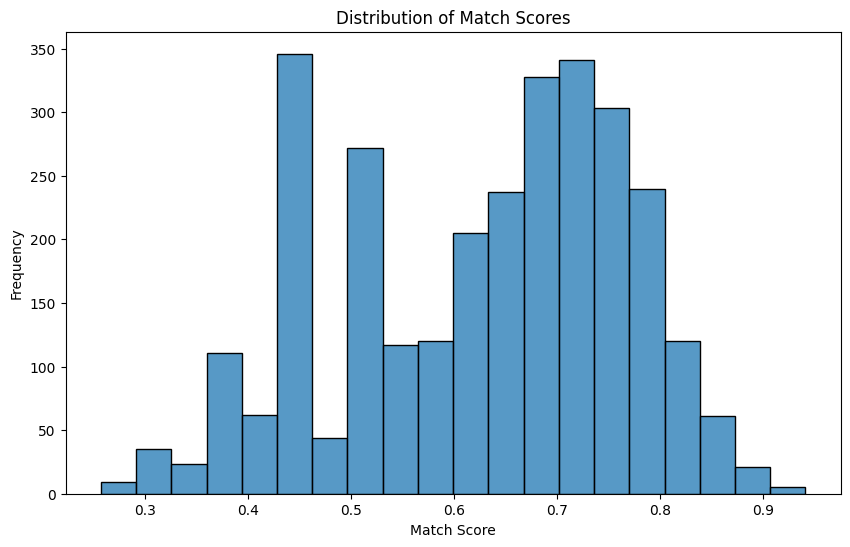

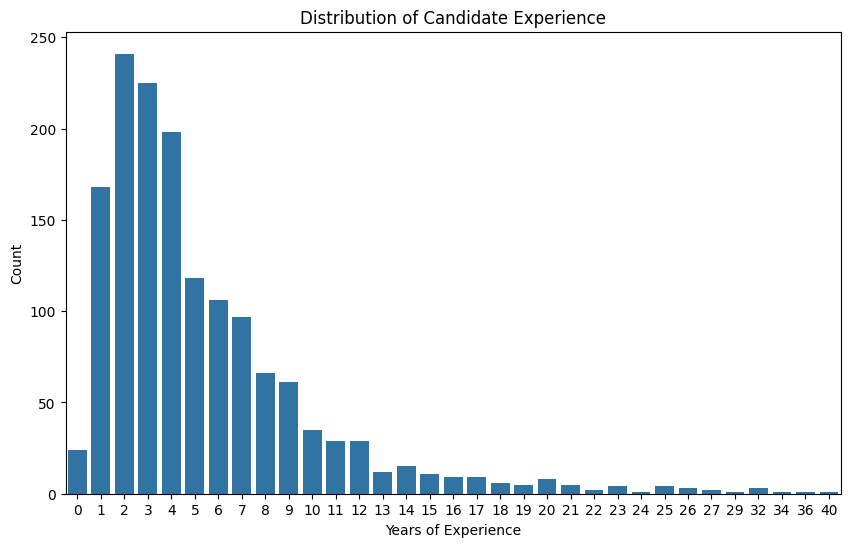

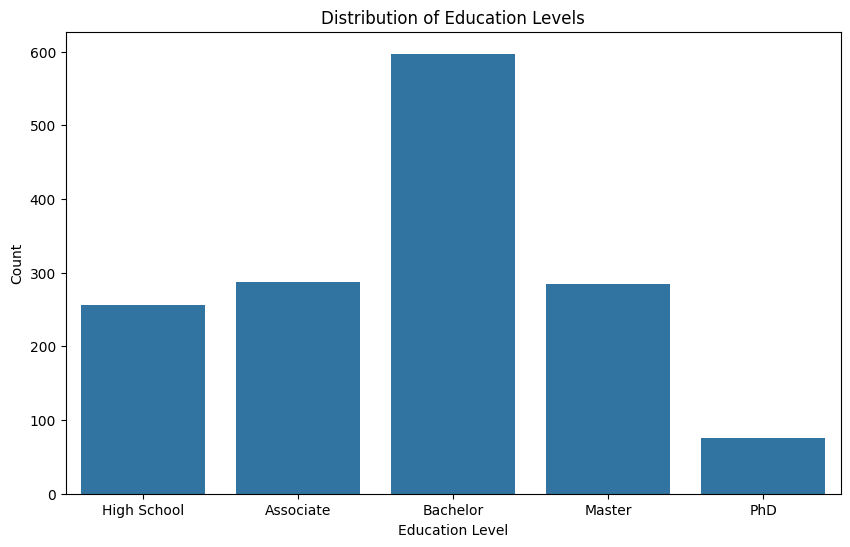

In [9]:
# Data Exploration and Visualization
# Explore the distribution of match scores
plt.figure(figsize=(10, 6))
sns.histplot(matches_df['match_score'], bins=20)
plt.title('Distribution of Match Scores')
plt.xlabel('Match Score')
plt.ylabel('Frequency')
plt.show()

# Explore candidate experience distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='experience', data=candidates_df)
plt.title('Distribution of Candidate Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Count')
plt.show()

# Explore education distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='education', data=candidates_df)
plt.title('Distribution of Education Levels')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.show()

In [6]:
# Feature Engineering - Creating Preprocessing Pipelines

# Create preprocessing pipelines for candidates
def create_candidate_preprocessor(candidates_df):
    # Define different transformers for different types of features

    # Text features - convert skills to TF-IDF vectors
    text_transformer = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=100, stop_words='english'))
    ])

    # Categorical features - one-hot encode education and location
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Numeric features - scale experience
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler())
    ])

    # Combine transformers using ColumnTransformer
    candidate_preprocessor = ColumnTransformer(
        transformers=[
            ('text', text_transformer, 'skills'),
            ('cat', categorical_transformer, ['education', 'location']),
            ('num', numeric_transformer, ['experience'])
        ],
        remainder='drop'  # Drop other columns not specified
    )

    # Fit the preprocessor on candidates data
    candidate_preprocessor.fit(candidates_df)

    return candidate_preprocessor

# Create preprocessing pipelines for jobs
def create_job_preprocessor(jobs_df):
    # Define different transformers for different types of features

    # Text features - convert required skills and title to TF-IDF vectors
    text_transformer = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=100, stop_words='english'))
    ])

    # Text features for job title
    title_transformer = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=50, stop_words='english'))
    ])

    # Categorical features - one-hot encode education and location
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Numeric features - scale minimum experience
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler())
    ])

    # Combine transformers using ColumnTransformer
    job_preprocessor = ColumnTransformer(
        transformers=[
            ('skills_text', text_transformer, 'required_skills'),
            ('title_text', title_transformer, 'title'),
            ('cat', categorical_transformer, ['required_education', 'location']),
            ('num', numeric_transformer, ['min_experience'])
        ],
        remainder='drop'  # Drop other columns not specified
    )

    # Fit the preprocessor on jobs data
    job_preprocessor.fit(jobs_df)

    return job_preprocessor

# Create and fit preprocessors
candidate_preprocessor = create_candidate_preprocessor(candidates_df)
job_preprocessor = create_job_preprocessor(jobs_df)

In [7]:
# Transform the data using preprocessors

# Transform candidate data
candidate_features = candidate_preprocessor.transform(candidates_df)
print(f"Candidate features shape: {candidate_features.shape}")

# Transform job data
job_features = job_preprocessor.transform(jobs_df)
print(f"Job features shape: {job_features.shape}")

Candidate features shape: (100, 29)
Job features shape: (50, 42)


In [8]:
# Prepare training data

def prepare_training_data(matches_df, candidates_df, jobs_df, candidate_features, job_features):
    # Create indices for faster lookups
    candidate_indices = {candidate_id: idx for idx, candidate_id in enumerate(candidates_df['id'])}
    job_indices = {job_id: idx for idx, job_id in enumerate(jobs_df['id'])}

    # Create training pairs and scores
    train_pairs = []
    match_scores = []

    for _, row in matches_df.iterrows():
        if row['candidate_id'] in candidate_indices and row['job_id'] in job_indices:
            candidate_idx = candidate_indices[row['candidate_id']]
            job_idx = job_indices[row['job_id']]

            train_pairs.append((candidate_idx, job_idx))
            match_scores.append(row['match_score'])

    # Convert to numpy arrays
    train_pairs = np.array(train_pairs)
    match_scores = np.array(match_scores)

    # Split into training and validation sets
    train_indices, val_indices = train_test_split(
        np.arange(len(train_pairs)),
        test_size=0.2,
        random_state=42
    )

    return train_pairs, match_scores, train_indices, val_indices

# Prepare training data
train_pairs, match_scores, train_indices, val_indices = prepare_training_data(
    matches_df, candidates_df, jobs_df, candidate_features, job_features
)

print(f"Number of training pairs: {len(train_indices)}")
print(f"Number of validation pairs: {len(val_indices)}")

Number of training pairs: 240
Number of validation pairs: 60


In [9]:
# Define the dual-encoder model architecture

def create_embedding_model(input_dim, name=None):
    """Create an encoder model that converts features to embeddings"""
    inputs = tf.keras.layers.Input(shape=(input_dim,))

    # First dense layer with dropout
    x = tf.keras.layers.Dense(256, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Second dense layer
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    # Final embedding layer (no activation for embeddings)
    embedding = tf.keras.layers.Dense(128)(x)

    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=embedding, name=name)
    return model

def create_matching_model(candidate_input_dim, job_input_dim):
    """Create the complete matching model with both encoders"""

    # Create encoders
    candidate_encoder = create_embedding_model(candidate_input_dim, "candidate_encoder")
    job_encoder = create_embedding_model(job_input_dim, "job_encoder")

    # Create inputs
    candidate_input = tf.keras.layers.Input(shape=(candidate_input_dim,), name="candidate_input")
    job_input = tf.keras.layers.Input(shape=(job_input_dim,), name="job_input")

    # Get embeddings from encoders
    candidate_embedding = candidate_encoder(candidate_input)
    job_embedding = job_encoder(job_input)

    # Normalize embeddings (for cosine similarity)
    normalized_candidate = tf.keras.layers.Lambda(
        lambda x: tf.math.l2_normalize(x, axis=1))(candidate_embedding)
    normalized_job = tf.keras.layers.Lambda(
        lambda x: tf.math.l2_normalize(x, axis=1))(job_embedding)

    # Calculate similarity (dot product of normalized vectors = cosine similarity)
    similarity = tf.keras.layers.Dot(axes=1)([normalized_candidate, normalized_job])

    # Scale the similarity to produce a match score
    match_score = tf.keras.layers.Dense(1, activation='sigmoid')(similarity)

    # Create the complete model
    model = tf.keras.Model(
        inputs=[candidate_input, job_input],
        outputs=match_score,
        name="matching_model"
    )

    # Also create separate models for inference
    candidate_model = tf.keras.Model(
        inputs=candidate_input,
        outputs=normalized_candidate,
        name="candidate_inference"
    )

    job_model = tf.keras.Model(
        inputs=job_input,
        outputs=normalized_job,
        name="job_inference"
    )

    return model, candidate_model, job_model

# Create the models
matching_model, candidate_model, job_model = create_matching_model(
    candidate_input_dim=candidate_features.shape[1],
    job_input_dim=job_features.shape[1]
)

# Print model summaries
print("Matching Model Summary:")
matching_model.summary()

print("\nCandidate Model Summary:")
candidate_model.summary()

print("\nJob Model Summary:")
job_model.summary()

Matching Model Summary:


Model: "matching_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ candidate_input     │ (None, 29)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ job_input           │ (None, 42)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ candidate_encoder   │ (None, 128)       │     57,088 │ candidate_input[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ job_encoder         │ (None, 128)       │     60,416 │ job_input[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ candidate_encode… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ job_encoder[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ lambda[0][0],     │
│                     │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │          2 │ dot[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 117,506 (459.01 KB)

 Trainable params: 117,506 (459.01 KB)

 Non-trainable params: 0 (0.00 B)


Candidate Model Summary:


Model: "candidate_inference"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ candidate_input (InputLayer)    │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ candidate_encoder (Functional)  │ (None, 128)            │        57,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,088 (223.00 KB)

 Trainable params: 57,088 (223.00 KB)

 Non-trainable params: 0 (0.00 B)


Job Model Summary:


Model: "job_inference"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ job_input (InputLayer)          │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ job_encoder (Functional)        │ (None, 128)            │        60,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,416 (236.00 KB)

 Trainable params: 60,416 (236.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model

# Compile the matching model
matching_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

# Create training and validation data
X_train = [
    candidate_features[train_pairs[train_indices, 0]].toarray(),
    job_features[train_pairs[train_indices, 1]].toarray()
]
y_train = match_scores[train_indices]

X_val = [
    candidate_features[train_pairs[val_indices, 0]].toarray(),
    job_features[train_pairs[val_indices, 1]].toarray()
]
y_val = match_scores[val_indices]

# Train the model
history = matching_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0222 - mae: 0.1095 - val_loss: 0.0161 - val_mae: 0.1015
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0151 - mae: 0.0958 - val_loss: 0.0155 - val_mae: 0.0930
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0119 - mae: 0.0782 - val_loss: 0.0146 - val_mae: 0.0884
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0085 - mae: 0.0673 - val_loss: 0.0136 - val_mae: 0.0873
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0090 - mae: 0.0671 - val_loss: 0.0121 - val_mae: 0.0803
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0055 - mae: 0.0524 - val_loss: 0.0121 - val_mae: 0.0833
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0053 - mae: 0.0513 - val_loss: 0.0109 - val_mae: 0.0778
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0037 - mae: 0.0408 - val_loss: 0.0105 - val_mae: 0.0776
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0039 - mae: 0.0430 - 

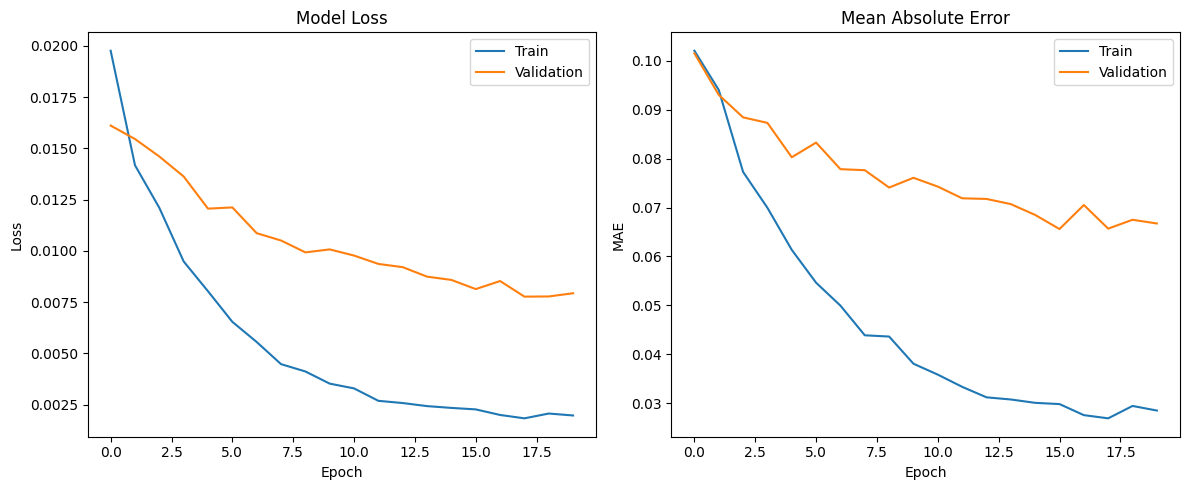

In [11]:
# Visualize training results

# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [12]:
# Evaluate the model on some examples

def predict_match_score(candidate_idx, job_idx):
    """Predict match score between a candidate and job"""
    # Get feature vectors
    candidate_vector = candidate_features[candidate_idx].toarray().reshape(1, -1)
    job_vector = job_features[job_idx].toarray().reshape(1, -1)

    # Predict match score
    score = matching_model.predict([candidate_vector, job_vector])[0][0]

    return score

# Select a few examples to test
test_examples = [
    (0, 0),  # First candidate, first job
    (0, 1),  # First candidate, second job
    (1, 0),  # Second candidate, first job
    (1, 1)   # Second candidate, second job
]

print("Example match predictions:")
for candidate_idx, job_idx in test_examples:
    score = predict_match_score(candidate_idx, job_idx)
    print(f"Candidate {candidates_df.iloc[candidate_idx]['id']} - "
          f"Job {jobs_df.iloc[job_idx]['id']}: "
          f"Score = {score:.4f}")

Example match predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Candidate 1 - Job 1: Score = 0.7547
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Candidate 1 - Job 2: Score = 0.4987
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Candidate 2 - Job 1: Score = 0.4732
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Candidate 2 - Job 2: Score = 0.5146


In [13]:
# Find top matching jobs for a candidate

def find_top_matching_jobs(candidate_idx, top_n=5):
    """Find the top N matching jobs for a candidate"""
    # Get candidate embedding
    candidate_vector = candidate_features[candidate_idx].toarray().reshape(1, -1)
    candidate_embedding = candidate_model.predict(candidate_vector)

    # Compute similarity with all jobs
    all_job_vectors = job_features.toarray()
    all_job_embeddings = job_model.predict(all_job_vectors)

    # Calculate cosine similarity (dot product of normalized vectors)
    similarities = np.dot(candidate_embedding, all_job_embeddings.T)[0]

    # Get top N job indices
    top_job_indices = np.argsort(similarities)[::-1][:top_n]

    # Return job information with scores
    results = []
    for job_idx in top_job_indices:
        job = jobs_df.iloc[job_idx]
        score = similarities[job_idx]

        results.append({
            'job_id': job['id'],
            'title': job['title'],
            'required_skills': job['required_skills'],
            'match_score': float(score)
        })

    return results

# Test for a specific candidate
candidate_idx = 3  # Fourth candidate
top_jobs = find_top_matching_jobs(candidate_idx, top_n=5)

print(f"Top matching jobs for Candidate {candidates_df.iloc[candidate_idx]['id']}:")
print(f"Skills: {candidates_df.iloc[candidate_idx]['skills']}")
print(f"Experience: {candidates_df.iloc[candidate_idx]['experience']} years")
print(f"Education: {candidates_df.iloc[candidate_idx]['education']}")
print("\nTop 5 matching jobs:")
for i, job in enumerate(top_jobs, 1):
    print(f"{i}. {job['title']} (ID: {job['job_id']}) - Score: {job['match_score']:.4f}")
    print(f"   Required skills: {job['required_skills']}")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Top matching jobs for Candidate 4:
Skills: java spring hibernate
Experience: 9 years
Education: High School

Top 5 matching jobs:
1. Data Analyst (ID: 29) - Score: 0.2563
   Required skills: sql python tableau

2. Data Analyst (ID: 39) - Score: 0.2463
   Required skills: sql python tableau

3. Data Analyst (ID: 49) - Score: 0.2438
   Required skills: sql python tableau

4. Data Analyst (ID: 19) - Score: 0.2095
   Required skills: sql python tableau

5. Web Developer (ID: 2) - Score: 0.2019
   Required skills: javascript html css



In [14]:
# Cell 13: Save the models and preprocessors
import os

# Create directory for saved models
os.makedirs('models', exist_ok=True)

# Save the models
matching_model.save('models/matching_model.h5')
candidate_model.save('models/candidate_model.h5')
job_model.save('models/job_model.h5')

# Save preprocessors
with open('models/candidate_preprocessor.pkl', 'wb') as f:
    pickle.dump(candidate_preprocessor, f)

with open('models/job_preprocessor.pkl', 'wb') as f:
    pickle.dump(job_preprocessor, f)

print("Models and preprocessors saved successfully!")

# Cell 14: Download saved models (for Google Colab)
from google.colab import files

# Zip the models directory
!zip -r models.zip models/

# Download the zip file
files.download('models.zip')

print("Download complete. The models.zip file contains all the saved models and preprocessors.")

Models and preprocessors saved successfully!
  adding: models/ (stored 0%)
  adding: models/job_model.h5 (deflated 14%)
  adding: models/job_preprocessor.pkl (deflated 54%)
  adding: models/candidate_model.h5 (deflated 15%)
  adding: models/matching_model.h5 (deflated 12%)
  adding: models/candidate_preprocessor.pkl (deflated 49%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download complete. The models.zip file contains all the saved models and preprocessors.
